# Distorting and undistorting points

Camera lenses produce distortions of an image. The calibration process aims to find parameters of these distortions, as well as the parameters of **3D** points projection onto an image plane. This recipe tells you how to apply a camera matrix and distortion coefficients to get undistorted image points and distort them back.

`cv2.undistortPoints` finds homogeneous coordinates for points in the image. This function removes lens distortion and unprojects the points so that they are in dimensionless coordinates. This function accepts the following arguments: an array of **2D** points in the image, a $3 \times 3$ camera matrix, a set of distortion coefficients, an object to store the result, and rectification and projection matrices, which are used in the stereo vision and aren't relevant now. The last three arguments are optional. `cv2.undistortPoints` returns the set of undistorted and unprojected points.

The points returned by `cv2.undistortPoints` are ideal—their coordinates are dimensionless and aren't distorted by lenses. If we need to project them back, we need to turn them into **3D** points. To do so, we just need to add the third $Z$ coordinate to each point. Because the coordinates of the points are homogeneous, $Z$ is equal to $1$.

When we have **3D** points and want to project them onto the image, `cv2.projectPoints` comes into play. In a general case, this function takes **3D** coordinates of points in some coordinate system, rotates and translates them to get the coordinates in the camera coordinate system, and then applies the camera matrix and distortion coefficients to find projections of the points onto the image plane.

The arguments for `cv2.projectPoints` are: an array of **3D** points in some local coordinate system, rotation and translation vectors of a transition from the local coordinate system to the camera coordinate system, a $3 \times 3$ camera matrix, an array of distortion coefficients, an object to store the resulting points, an object to store Jacobian values, and the value of the aspect ratio. Again, the last three parameters are optional and can be omitted. This function returns the projected and distorted coordinates of the **3D** points and Jacobian values. If you want to get the positions of points without lenses distortion, you can pass None as the value of the distortion coefficients array.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    #plt.gca().invert_yaxis() plt.gca().invert_xaxis()
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S09\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s09\env

d:\html_doc\program\opencv\packt\s09\env\lib\site-packages
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\pip-20.1-py3.8.egg
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S09\env


------  data/pinhole_calib/img_00.png    Shape(480, 640, 3) image_orig: uint8
[[44 44 44] [42 42 42] [42 42 42] [43 43 43] [41 45 49] [41 45 49] [43 47 48] ]
[[44 44 44] [44 44 44] [42 41 43] [43 42 45] [44 43 46] [44 43 46] [41 45 49] ]
[[44 44 44] [45 45 45] [39 44 43] [40 45 44] [39 46 47] [38 45 46] [39 45 49] ]
[[39 43 45] [43 47 48] [39 43 45] [40 44 46] [39 45 49] [38 44 47] [37 43 46] ]
[[40 45 44] [40 45 44] [40 45 44] [40 45 44] [40 44 46] [40 44 46] [37 43 45] ]
[[43 43 43] [42 42 42] [43 43 43] [43 43 43] [43 42 45] [44 43 46] [40 44 46] ]
[[41 41 41] [41 41 41] [41 41 41] [42 42 42] [42 42 42] [42 42 42] [43 43 43] ]


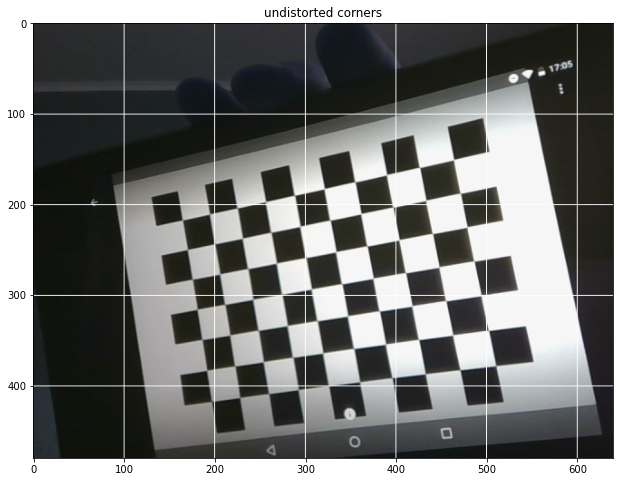

In [2]:
image_orig = cv2.imread('data/pinhole_calib/img_00.png')
pattern_size = (10, 7)



#############################################################
print_image('data/pinhole_calib/img_00.png','image_orig',image_orig,0,7,0,7)
plt_view_image(plt,[["undistorted corners", draw_grid(np.copy(image_orig),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

No handles with labels found to put in legend.


True
------  corners------------------    Shape(70, 1, 2) corners: float32
[[163.65352 216.69199] ]
[[195.55397 210.07597] ]
[[223.92934 203.41312] ]
[[257.47073 196.18645] ]
[[287.72662 189.47139] ]
[[322.1432  182.32362] ]
[[355.4276  175.44026] ]


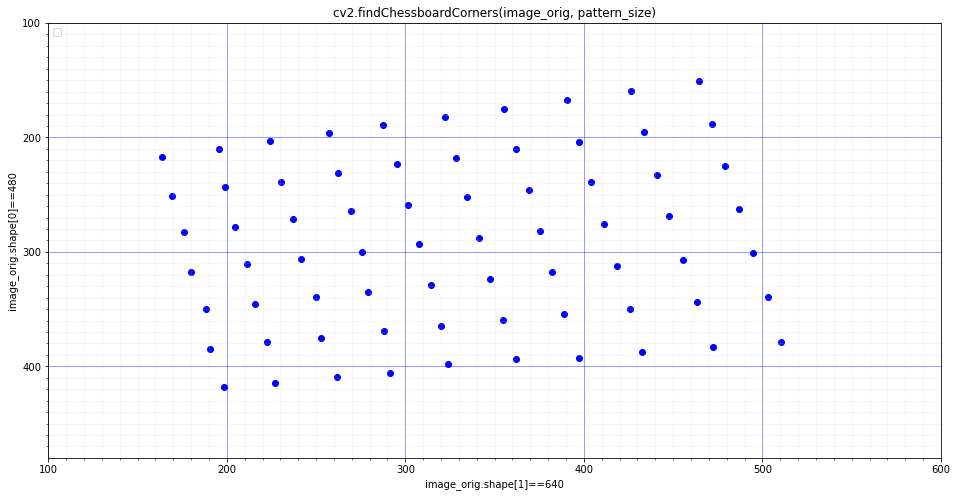

In [3]:
res, corners = cv2.findChessboardCorners(image_orig, pattern_size)



#############################################################
print(res)
print_image('corners','corners',corners,0,7,0,7)

plt.figure(figsize=(16,8))
plt_view_grid(plt, 'on',(100,600,100,480),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()


plt.scatter(corners[:,:,0], corners[:,:,1], color='blue')
plt.xlabel('image_orig.shape[1]=={}'.format(image_orig.shape[1]));
plt.ylabel('image_orig.shape[0]=={}'.format(image_orig.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')
plt.show()

In [4]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
cornersSubPix = cv2.cornerSubPix(cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY), corners, 
                                 (10, 10),(-1,-1),criteria)



##############################################################
print_image('corners','corners',corners,0,7,0,7)
print_image('cornersSubPix','cornersSubPix',cornersSubPix,0,7,0,7)

------  corners------------------    Shape(70, 1, 2) corners: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]
------  cornersSubPix------------    Shape(70, 1, 2) cornersSubPix: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]


In [5]:
camera_matrix = np.load('data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('data/pinhole_calib/dist_coefs.npy')


h_corners = cv2.undistortPoints(cornersSubPix, camera_matrix, dist_coefs)
h_corners = np.c_[h_corners.squeeze(), np.ones(len(h_corners))]



##############################################################
print_image('corners','corners',corners,0,7,0,7)
print_image('h_corners','h_corners',h_corners,0,7,0,7)

------  corners------------------    Shape(70, 1, 2) corners: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]
------  h_corners----------------    Shape(70, 3) h_corners: float64
[ -0.2694566249847412 -0.028696494176983833 1.0 ]
[ -0.22137275338172913 -0.03934111073613167 1.0 ]
[ -0.17224174737930298 -0.05023025721311569 1.0 ]
[ -0.12148699164390564 -0.06149738281965256 1.0 ]
[ -0.06954783946275711 -0.07307246327400208 1.0 ]
[ -0.015953166410326958 -0.08513791114091873 1.0 ]
[ 0.039129044860601425 -0.09727746993303299 1.0 ]


No handles with labels found to put in legend.


------  corners------------------    Shape(70, 1, 2) corners: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]
------  img_pts_None-------------    Shape(70, 1, 2) img_pts_None: float64
[[165.81394823 217.41654577] ]
[[195.32020401 210.89161856] ]
[[225.46902485 204.21679963] ]
[[256.6142458  197.31028741] ]
[[288.48626148 190.2150053 ] ]
[[321.37417336 182.81913824] ]
[[355.17490031 175.37784273] ]


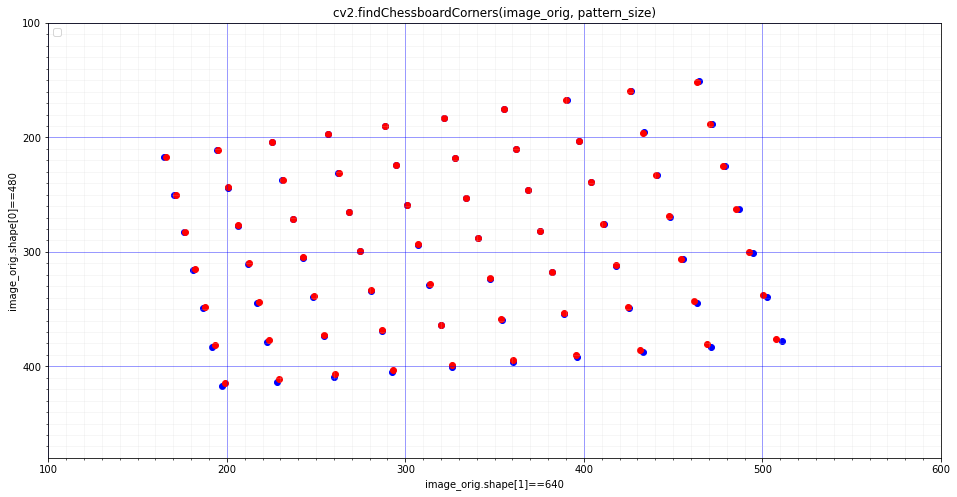

In [6]:
img_pts_None, _ = cv2.projectPoints(h_corners, (0, 0, 0), (0, 0, 0), camera_matrix, None)



#############################################################
print_image('corners','corners',corners,0,7,0,7)
print_image('img_pts_None','img_pts_None',img_pts_None,0,7,0,7)

plt.figure(figsize=(16,8))
plt_view_grid(plt, 'on',(100,600,100,480),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()

plt.scatter(corners[:,:,0], corners[:,:,1],color='blue')
plt.scatter(img_pts_None[:,:,0], img_pts_None[:,:,1],color='red')
plt.xlabel('image_orig.shape[1]=={}'.format(image_orig.shape[1]));
plt.ylabel('image_orig.shape[0]=={}'.format(image_orig.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')
plt.show()

<ipython-input-7-6d71af775810>:3: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image_None, tuple(c[0]), 10, (0, 255, 0), 2)
<ipython-input-7-6d71af775810>:6: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image_None, tuple(c), 5, (0, 0, 255), 2)


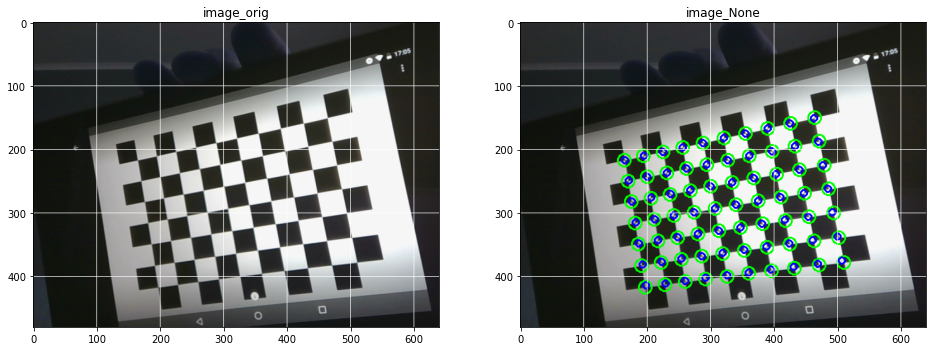

In [7]:
image_None = np.copy(image_orig)
for c in corners:
    cv2.circle(image_None, tuple(c[0]), 10, (0, 255, 0), 2)

for c in img_pts_None.squeeze().astype(np.float32):
    cv2.circle(image_None, tuple(c), 5, (0, 0, 255), 2)

    

#############################################################
plt_view_image(plt,[["image_orig", draw_grid(np.copy(image_orig),100,(255,255,255))],
                    ["image_None", draw_grid(np.copy(image_None),100,(255,255,255))],
                   ],
               figsize=(16,8), axis='on', cmap='gray')

cv2.imshow('image_orig, image_None', 
           np.hstack([ draw_grid(np.copy(image_orig),100,(255,255,255)),
                       draw_grid(np.copy(image_None),100,(255,255,255))]))
cv2.waitKey()
cv2.destroyAllWindows()

No handles with labels found to put in legend.


------  corners------------------    Shape(70, 1, 2) corners: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]
------  img_pts_None-------------    Shape(70, 1, 2) img_pts_None: float64
[[165.81394823 217.41654577] ]
[[195.32020401 210.89161856] ]
[[225.46902485 204.21679963] ]
[[256.6142458  197.31028741] ]
[[288.48626148 190.2150053 ] ]
[[321.37417336 182.81913824] ]
[[355.17490031 175.37784273] ]
------  img_pts_dist_coefs-------    Shape(70, 1, 2) img_pts_dist_coefs: float64
[[164.77907544 217.36672995] ]
[[194.77329885 210.83123799] ]
[[225.23079256 204.16589429] ]
[[256.54013    197.27816877] ]
[[288.47473091 190.19847202] ]
[[321.37939506 182.80091814] ]
[[355.21533158 175.32438656] ]


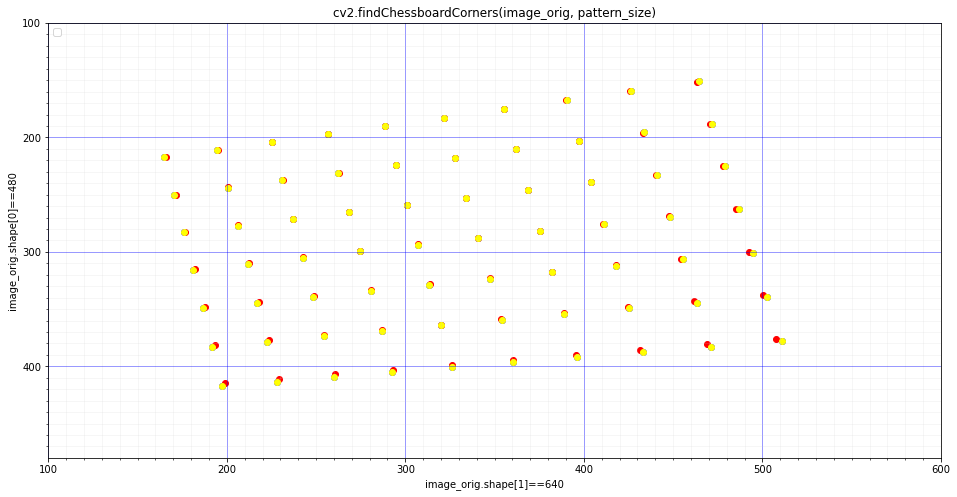

In [8]:
img_pts_dist_coefs, _ = cv2.projectPoints(h_corners, (0, 0, 0), (0, 0, 0), camera_matrix, dist_coefs)


#############################################################
print_image('corners','corners',corners,0,7,0,7)
print_image('img_pts_None','img_pts_None',img_pts_None,0,7,0,7)
print_image('img_pts_dist_coefs','img_pts_dist_coefs',img_pts_dist_coefs,0,7,0,7)


plt.figure(figsize=(16,8))
plt_view_grid(plt, 'on',(100,600,100,480),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()

plt.scatter(corners[:,:,0],           corners[:,:,1],           color='blue')
plt.scatter(img_pts_None[:,:,0],      img_pts_None[:,:,1],      color='red')
plt.scatter(img_pts_dist_coefs[:,:,0],img_pts_dist_coefs[:,:,1],color='yellow')
plt.xlabel('image_orig.shape[1]=={}'.format(image_orig.shape[1]));
plt.ylabel('image_orig.shape[0]=={}'.format(image_orig.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')
plt.show()

<ipython-input-9-26e32f92013d>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image_dist_coefs, tuple(c), 2, (255, 255, 0), 2)
<ipython-input-9-26e32f92013d>:6: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image_dist, tuple(c), 2, (255, 255, 0), 2)


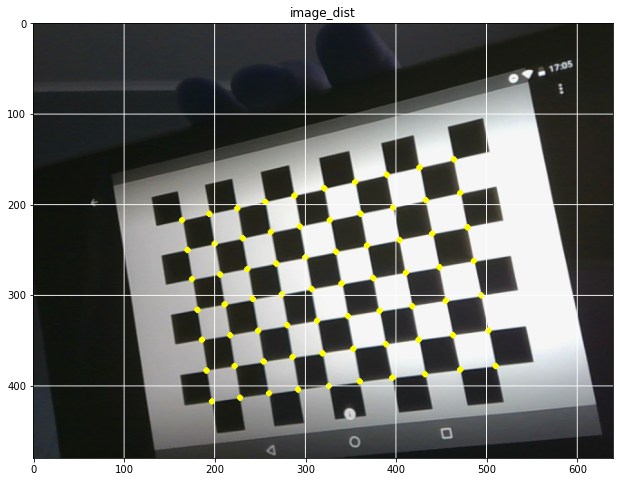

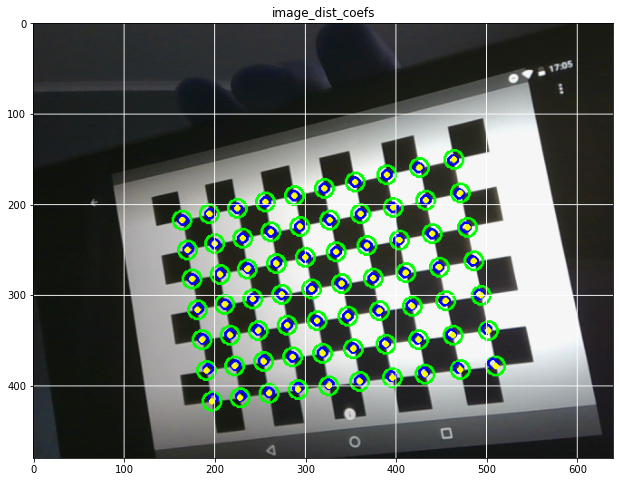

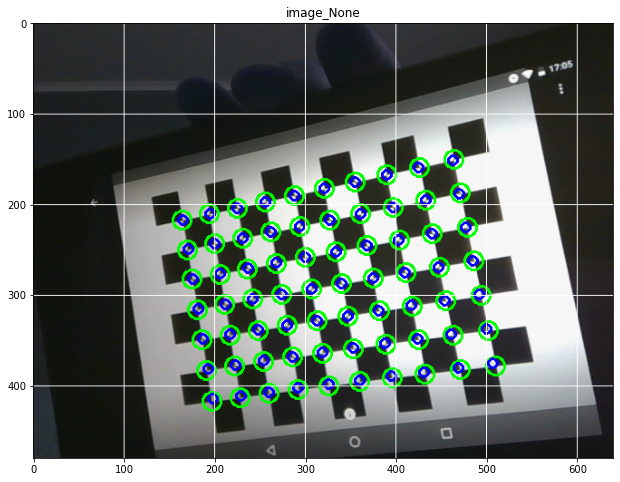

In [9]:
image_dist = np.copy(image_orig)
image_dist_coefs = np.copy(image_None)

for c in img_pts_dist_coefs.squeeze().astype(np.float32):
    cv2.circle(image_dist_coefs, tuple(c), 2, (255, 255, 0), 2)
    cv2.circle(image_dist, tuple(c), 2, (255, 255, 0), 2)
    



#############################################################
plt_view_image(plt,[["image_dist", draw_grid(np.copy(image_dist),100,(255,255,255))]],
                    figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["image_dist_coefs", draw_grid(np.copy(image_dist_coefs),100,(255,255,255))]],
                    figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["image_None", draw_grid(np.copy(image_None),100,(255,255,255))]],
                    figsize=(16,8), axis='on', cmap='gray')
      
cv2.imshow('image_None, reprojected corners', 
           np.hstack([draw_grid(np.copy(image_dist_coefs),100,(255,255,255)),
                      draw_grid(np.copy(image_None),100,(255,255,255))]))
cv2.waitKey()
cv2.destroyAllWindows()